In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup
import batman # batman-package (Bad-Ass Transit Model cAlculatioN)

## Generate simulated data with Jupiter-size planet transit

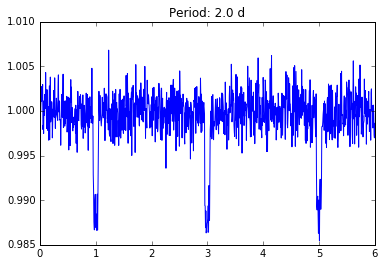

In [30]:
params = batman.TransitParams() # object to store the transit parameters
params.t0 = 1.0 # time of inferior conjunction 
params.per = 2.0 # orbital period (days)
params.rp = R_jup/R_sun # planet radius (in units of stellar radii)

a = (((params.per*u.day)**2 * G * (M_sun + M_jup) / (4*np.pi**2))**(1./3)).to(R_sun).value # calculate semi-major axis for orbital period value 

params.a = a # semi-major axis (in units of stellar radii)
params.inc = 90.0  # orbital inclination (in degrees)
params.ecc = 0. # eccentricity
params.w = 90. # longitude of periastron (in degrees), 90 for circular
params.u = [0.1, 0.3] # limb darkening coefficients
params.limb_dark = "quadratic" # limb darkening model

t = np.linspace(0.0, 6.0, 1000) # times at which to calculate the light curve
m = batman.TransitModel(params, t) # initializes the model
f = m.light_curve(params)

# add gaussian error 
rs = np.random.RandomState(seed=13)

errors = 0.002*np.ones_like(f)
f += errors*rs.randn(len(t))

plt.plot(t, f)
plt.title("Period: {0} d".format(params.per))

## Compute the BLS spectrum

Recovered period: 1.98948948949
Actual period: 2.0


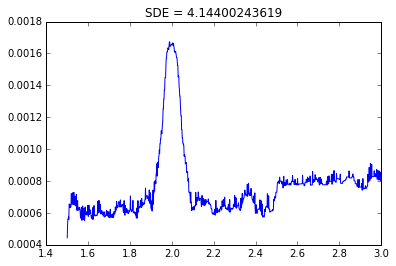

In [39]:
def signal_residue(folded_flux, folded_error, weights, i_1, i_2):
    """Calculate Signal Residue (SR) in eq. 5"""
    r = np.sum(weights[i_1:i_2])
    s = np.sum(weights[i_1:i_2] * folded_flux[i_1:i_2])
    return np.sqrt( s**2/(r*(1.0 - r)) )

def calculate_weights(folded_errors):
    return folded_errors**(-2)/np.sum(folded_errors**(-2))

def bls(times, fluxes, errors, min_period, max_period, n_periods, transit_window):
    fluxes = fluxes.copy() - np.mean(fluxes) # data centering
    
    trial_periods = np.linspace(min_period, max_period, n_periods) # trial period
    
    spectrum = np.zeros(len(trial_periods)) # initialize
    
    for i, trial_period in enumerate(trial_periods):
        folded_t = times % trial_period # data folding
        sorted_args = np.argsort(folded_t)
        folded_f = fluxes[sorted_args]
        folded_e = errors[sorted_args]
        
        weights = calculate_weights(folded_e)
        
        i1 = np.arange(len(times) - transit_window) # transit phase
        i2 = np.arange(transit_window, len(times))
        
        sr = np.zeros(len(i1)) # signal residue
        
        for i1, i2 in zip(i1,i2): # iteration on a single trial period
            sr[i1] = signal_residue(folded_f, folded_e, weights, i1, i2)
        
        spectrum[i] = np.max(sr)
    
    return trial_periods, spectrum

trial_periods, spectrum = bls(t, f, errors, 1.5, 3.0, 1000, 20)
sde = (np.max(spectrum) - np.mean(spectrum))/np.std(spectrum) # signal detection efficiency

plt.plot(trial_periods, spectrum)
plt.title("SDE = {0}".format(sde))

print("Recovered period: {0}\nActual period: {1}".format(trial_periods[np.argmax(spectrum)], params.per))